
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [16]:
import gym
# Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [17]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.01518441  0.18851632 -0.00140159 -0.31538359] 1 1.0 False {}
state, action, reward, done, info
[-0.01141408 -0.00658563 -0.00770927 -0.02314301] 0 1.0 False {}
state, action, reward, done, info
[-0.01154579 -0.20159618 -0.00817213  0.26709762] 0 1.0 False {}
state, action, reward, done, info
[-0.01557772 -0.00635856 -0.00283017 -0.02815162] 1 1.0 False {}
state, action, reward, done, info
[-0.01570489 -0.20143981 -0.00339321  0.26363702] 0 1.0 False {}
state, action, reward, done, info
[-0.01973368 -0.39651316  0.00187953  0.55524776] 0 1.0 False {}
state, action, reward, done, info
[-0.02766395 -0.59166146  0.01298449  0.84852226] 0 1.0 False {}
state, action, reward, done, info
[-0.03949718 -0.78695807  0.02995493  1.14525983] 0 1.0 False {}
state, action, reward, done, info
[-0.05523634 -0.98245821  0.05286013  1.44718391] 0 1.0 False {}
state, action, reward, done, info
[-0.0748855  -0.7880247   0.08180381  1.17147465] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [18]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.4471839063420644 -0.98245820723593


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [19]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [20]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [21]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [22]:
# D: Descriminator/Reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [23]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states):
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(actions, action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, g_loss, d_loss, rewards_fake, rewards_real

In [24]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [25]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.g_loss, self.d_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, g_loss=self.g_loss, d_loss=self.d_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [26]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [36]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 8                # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 200                # experience mini-batch size
learning_rate = 0.001           # learning rate for adam

In [37]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [38]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [39]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
q_loss_list, g_loss_list, d_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     saver.restore(sess, 'checkpoints/Q-GAN-cartpole.ckpt')    
    #     #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        q_loss, g_loss, d_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, 
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/QGAN-cartpole-v1.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 36.0 Average reward fake: 0.5017061829566956 Average reward real: 0.5081115961074829 Training q_loss: 0.2705 Training g_loss: 0.6897 Training d_loss: 1.3741 Explore P: 0.9964
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 16.0 Average reward fake: 0.4987774193286896 Average reward real: 0.5021291375160217 Training q_loss: 0.2769 Training g_loss: 0.6956 Training d_loss: 1.3802 Explore P: 0.9949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 28.0 Average reward fake: 0.49272608757019043 Average reward real: 0.4953713119029999 Training q_loss: 0.3128 Training g_loss: 0.7078 Training d_loss: 1.3813 Explore P: 0.9921

-------------------------------------------------------------------------------
Episode: 23 Total reward: 44.0 Average reward fake: 0.5713395476341248 Average reward real: 0.651171088218689 Training q_loss: 7.2075 Training g_loss: 0.5591 Training d_loss: 1.3039 Explore P: 0.9519
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 22.0 Average reward fake: 0.5340521931648254 Average reward real: 0.5039762854576111 Training q_loss: 11.2752 Training g_loss: 0.6272 Training d_loss: 1.4576 Explore P: 0.9498
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 28.0 Average reward fake: 0.5064389705657959 Average reward real: 0.4758588671684265 Training q_loss: 8.4654 Training g_loss: 0.6803 Training d_loss: 1.4580 Explore P: 0.94

-------------------------------------------------------------------------------
Episode: 46 Total reward: 15.0 Average reward fake: 0.4365747570991516 Average reward real: 0.5178534984588623 Training q_loss: 3.7021 Training g_loss: 0.8288 Training d_loss: 1.2519 Explore P: 0.9027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 14.0 Average reward fake: 0.4187493920326233 Average reward real: 0.5407016277313232 Training q_loss: 4.2916 Training g_loss: 0.8706 Training d_loss: 1.1763 Explore P: 0.9014
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 14.0 Average reward fake: 0.3868756890296936 Average reward real: 0.5676698088645935 Training q_loss: 2.1896 Training g_loss: 0.9507 Training d_loss: 1.0768 Explore P: 0.90

-------------------------------------------------------------------------------
Episode: 69 Total reward: 24.0 Average reward fake: 0.43962547183036804 Average reward real: 0.5262677669525146 Training q_loss: 8.3795 Training g_loss: 0.8871 Training d_loss: 1.2923 Explore P: 0.8554
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 14.0 Average reward fake: 0.41806933283805847 Average reward real: 0.5518078804016113 Training q_loss: 7.5863 Training g_loss: 0.9782 Training d_loss: 1.2558 Explore P: 0.8542
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 20.0 Average reward fake: 0.442574143409729 Average reward real: 0.5807209014892578 Training q_loss: 8.3048 Training g_loss: 0.9746 Training d_loss: 1.3109 Explore P: 0.8

-------------------------------------------------------------------------------
Episode: 92 Total reward: 26.0 Average reward fake: 0.4721125066280365 Average reward real: 0.5040982961654663 Training q_loss: 3.2742 Training g_loss: 0.7565 Training d_loss: 1.3458 Explore P: 0.8010
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 48.0 Average reward fake: 0.5716599822044373 Average reward real: 0.48087266087532043 Training q_loss: 6.5243 Training g_loss: 0.5603 Training d_loss: 1.6183 Explore P: 0.7972
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 79.0 Average reward fake: 0.545215904712677 Average reward real: 0.47382548451423645 Training q_loss: 9.5498 Training g_loss: 0.6068 Training d_loss: 1.5395 Explore P: 0.7

-------------------------------------------------------------------------------
Episode: 116 Total reward: 62.0 Average reward fake: 0.44995057582855225 Average reward real: 0.4834531545639038 Training q_loss: 37.1481 Training g_loss: 0.8155 Training d_loss: 1.3518 Explore P: 0.7290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 102.0 Average reward fake: 0.5637447834014893 Average reward real: 0.4540768563747406 Training q_loss: 8.5519 Training g_loss: 0.5742 Training d_loss: 1.6356 Explore P: 0.7217
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 118 Total reward: 18.0 Average reward fake: 0.5669030547142029 Average reward real: 0.4939817190170288 Training q_loss: 27.0670 Training g_loss: 0.5681 Training d_loss: 1.5488 Explore 

-------------------------------------------------------------------------------
Episode: 140 Total reward: 98.0 Average reward fake: 0.4791470766067505 Average reward real: 0.491926372051239 Training q_loss: 14.0819 Training g_loss: 0.7361 Training d_loss: 1.3747 Explore P: 0.6505
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 60.0 Average reward fake: 0.5036787986755371 Average reward real: 0.4960366189479828 Training q_loss: 89.8952 Training g_loss: 0.6859 Training d_loss: 1.4103 Explore P: 0.6466
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 57.0 Average reward fake: 0.5037011504173279 Average reward real: 0.5075405836105347 Training q_loss: 42.9074 Training g_loss: 0.6859 Training d_loss: 1.3806 Explore P:

-------------------------------------------------------------------------------
Episode: 164 Total reward: 50.0 Average reward fake: 0.4571015238761902 Average reward real: 0.5370845794677734 Training q_loss: 171.3239 Training g_loss: 0.7831 Training d_loss: 1.2357 Explore P: 0.5598
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 166 Total reward: 20.0 Average reward fake: 0.5226726531982422 Average reward real: 0.49336883425712585 Training q_loss: 347.2107 Training g_loss: 0.6488 Training d_loss: 1.4515 Explore P: 0.5479
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 98.0 Average reward fake: 0.5172663927078247 Average reward real: 0.5070146918296814 Training q_loss: 349.5676 Training g_loss: 0.6594 Training d_loss: 1.4126 Explo

-------------------------------------------------------------------------------
Episode: 195 Total reward: 47.0 Average reward fake: 0.4888877868652344 Average reward real: 0.4958847761154175 Training q_loss: 450.6889 Training g_loss: 0.7160 Training d_loss: 1.3747 Explore P: 0.3923
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 197 Total reward: 9.0 Average reward fake: 0.49432334303855896 Average reward real: 0.5119237303733826 Training q_loss: 365.4318 Training g_loss: 0.7086 Training d_loss: 1.3596 Explore P: 0.3844
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 198 Total reward: 76.0 Average reward fake: 0.5022915005683899 Average reward real: 0.5024457573890686 Training q_loss: 1382.9932 Training g_loss: 0.6918 Training d_loss: 1.3920 Explo

-------------------------------------------------------------------------------
Episode: 236 Total reward: 44.0 Average reward fake: 0.4771290719509125 Average reward real: 0.5043630599975586 Training q_loss: 1017.8812 Training g_loss: 0.7400 Training d_loss: 1.3349 Explore P: 0.2244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 238 Total reward: 108.0 Average reward fake: 0.5156616568565369 Average reward real: 0.4705003798007965 Training q_loss: 764.0876 Training g_loss: 0.6624 Training d_loss: 1.4799 Explore P: 0.2179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 240 Total reward: 10.0 Average reward fake: 0.5277225375175476 Average reward real: 0.5004070401191711 Training q_loss: 320.8237 Training g_loss: 0.6392 Training d_loss: 1.4460 Expl

-------------------------------------------------------------------------------
Episode: 281 Total reward: 39.0 Average reward fake: 0.4860546588897705 Average reward real: 0.5085055828094482 Training q_loss: 154.5483 Training g_loss: 0.7215 Training d_loss: 1.3474 Explore P: 0.1278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 283 Total reward: 115.0 Average reward fake: 0.47628745436668396 Average reward real: 0.5271437168121338 Training q_loss: 242.3604 Training g_loss: 0.7424 Training d_loss: 1.3047 Explore P: 0.1242
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 285 Total reward: 72.0 Average reward fake: 0.4466257095336914 Average reward real: 0.5183780789375305 Training q_loss: 92.1180 Training g_loss: 0.8078 Training d_loss: 1.2643 Explo

-------------------------------------------------------------------------------
Episode: 325 Total reward: 61.0 Average reward fake: 0.4973611533641815 Average reward real: 0.5757048726081848 Training q_loss: 79.7169 Training g_loss: 0.7945 Training d_loss: 1.3751 Explore P: 0.0743
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 200.0 Average reward fake: 0.49759018421173096 Average reward real: 0.44816291332244873 Training q_loss: 82.7116 Training g_loss: 0.6980 Training d_loss: 1.5014 Explore P: 0.0730
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 328 Total reward: 27.0 Average reward fake: 0.4959605038166046 Average reward real: 0.5082066655158997 Training q_loss: 94.4532 Training g_loss: 0.7047 Training d_loss: 1.3787 Explor

-------------------------------------------------------------------------------
Episode: 370 Total reward: 99.0 Average reward fake: 0.5241697430610657 Average reward real: 0.5870459079742432 Training q_loss: 75.7621 Training g_loss: 0.6579 Training d_loss: 1.3034 Explore P: 0.0441
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 373 Total reward: 99.0 Average reward fake: 0.47156715393066406 Average reward real: 0.5242781639099121 Training q_loss: 116.2340 Training g_loss: 0.7546 Training d_loss: 1.3449 Explore P: 0.0425
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 376 Total reward: 99.0 Average reward fake: 0.5066839456558228 Average reward real: 0.4470541775226593 Training q_loss: 62.9350 Training g_loss: 0.6802 Training d_loss: 1.5307 Explore

-------------------------------------------------------------------------------
Episode: 426 Total reward: 183.0 Average reward fake: 0.5285255312919617 Average reward real: 0.44582676887512207 Training q_loss: 1104.4493 Training g_loss: 0.6378 Training d_loss: 1.5764 Explore P: 0.0240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 428 Total reward: 97.0 Average reward fake: 0.49332404136657715 Average reward real: 0.49961283802986145 Training q_loss: 109.2905 Training g_loss: 0.7067 Training d_loss: 1.3935 Explore P: 0.0235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 430 Total reward: 198.0 Average reward fake: 0.5652954578399658 Average reward real: 0.46933722496032715 Training q_loss: 120.6600 Training g_loss: 0.5706 Training d_loss: 1.6079

-------------------------------------------------------------------------------
Episode: 476 Total reward: 153.0 Average reward fake: 0.4976354241371155 Average reward real: 0.4892752468585968 Training q_loss: 30.5087 Training g_loss: 0.6979 Training d_loss: 1.4053 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 478 Total reward: 25.0 Average reward fake: 0.4891777038574219 Average reward real: 0.514466404914856 Training q_loss: 34.0206 Training g_loss: 0.7150 Training d_loss: 1.3403 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 480 Total reward: 6.0 Average reward fake: 0.5395515561103821 Average reward real: 0.4855639338493347 Training q_loss: 34.4981 Training g_loss: 0.6172 Training d_loss: 1.5033 Explore P:

-------------------------------------------------------------------------------
Episode: 506 Total reward: 191.0 Average reward fake: 0.5052649974822998 Average reward real: 0.4615699052810669 Training q_loss: 15.0741 Training g_loss: 0.6827 Training d_loss: 1.4774 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 507 Total reward: 194.0 Average reward fake: 0.4562239944934845 Average reward real: 0.5393354296684265 Training q_loss: 14.1328 Training g_loss: 0.7854 Training d_loss: 1.2312 Explore P: 0.0141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 11.0 Average reward fake: 0.4662410020828247 Average reward real: 0.5779156684875488 Training q_loss: 26.5423 Training g_loss: 0.7637 Training d_loss: 1.1820 Explore

-------------------------------------------------------------------------------
Episode: 538 Total reward: 62.0 Average reward fake: 0.4828301966190338 Average reward real: 0.5037413239479065 Training q_loss: 11.9078 Training g_loss: 0.7281 Training d_loss: 1.3475 Explore P: 0.0126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 5.0 Average reward fake: 0.5133397579193115 Average reward real: 0.5866838693618774 Training q_loss: 44.0512 Training g_loss: 0.6723 Training d_loss: 1.2750 Explore P: 0.0126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 542 Total reward: 21.0 Average reward fake: 0.4999037981033325 Average reward real: 0.4476625323295593 Training q_loss: 8.0184 Training g_loss: 0.6936 Training d_loss: 1.4997 Explore P: 

-------------------------------------------------------------------------------
Episode: 574 Total reward: 51.0 Average reward fake: 0.6160838603973389 Average reward real: 0.4666346609592438 Training q_loss: 4.5107 Training g_loss: 0.4848 Training d_loss: 1.7462 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 576 Total reward: 20.0 Average reward fake: 0.4489613473415375 Average reward real: 0.4993935525417328 Training q_loss: 4.7079 Training g_loss: 0.8008 Training d_loss: 1.2947 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 578 Total reward: 81.0 Average reward fake: 0.4874616861343384 Average reward real: 0.49659955501556396 Training q_loss: 3.6849 Training g_loss: 0.7186 Training d_loss: 1.3697 Explore P: 

-------------------------------------------------------------------------------
Episode: 624 Total reward: 125.0 Average reward fake: 0.4249437749385834 Average reward real: 0.4754667282104492 Training q_loss: 3.6873 Training g_loss: 0.8581 Training d_loss: 1.3051 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 626 Total reward: 197.0 Average reward fake: 0.4746413826942444 Average reward real: 0.5066217184066772 Training q_loss: 12.2594 Training g_loss: 0.7459 Training d_loss: 1.3339 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 628 Total reward: 108.0 Average reward fake: 0.47790291905403137 Average reward real: 0.5229006409645081 Training q_loss: 3.7434 Training g_loss: 0.7393 Training d_loss: 1.3023 Explore

-------------------------------------------------------------------------------
Episode: 672 Total reward: 74.0 Average reward fake: 0.4600795805454254 Average reward real: 0.525123655796051 Training q_loss: 2.7686 Training g_loss: 0.7844 Training d_loss: 1.2849 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 674 Total reward: 43.0 Average reward fake: 0.49170273542404175 Average reward real: 0.5190469622612 Training q_loss: 4.0175 Training g_loss: 0.7150 Training d_loss: 1.3404 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 676 Total reward: 41.0 Average reward fake: 0.5137070417404175 Average reward real: 0.48896124958992004 Training q_loss: 3.7755 Training g_loss: 0.6661 Training d_loss: 1.4374 Explore P: 0.0

-------------------------------------------------------------------------------
Episode: 720 Total reward: 99.0 Average reward fake: 0.3926759958267212 Average reward real: 0.37734144926071167 Training q_loss: 2.3904 Training g_loss: 0.9380 Training d_loss: 1.5214 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 722 Total reward: 72.0 Average reward fake: 0.45556557178497314 Average reward real: 0.47067320346832275 Training q_loss: 0.8045 Training g_loss: 0.7951 Training d_loss: 1.4007 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 724 Total reward: 78.0 Average reward fake: 0.4577975571155548 Average reward real: 0.4812368154525757 Training q_loss: 1.3129 Training g_loss: 0.8122 Training d_loss: 1.4043 Explore P

-------------------------------------------------------------------------------
Episode: 773 Total reward: 63.0 Average reward fake: 0.5014848113059998 Average reward real: 0.5110844969749451 Training q_loss: 6.5008 Training g_loss: 0.6920 Training d_loss: 1.3711 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 775 Total reward: 111.0 Average reward fake: 0.5101113319396973 Average reward real: 0.4660152494907379 Training q_loss: 1.1102 Training g_loss: 0.6736 Training d_loss: 1.4783 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 777 Total reward: 108.0 Average reward fake: 0.4850246012210846 Average reward real: 0.49164918065071106 Training q_loss: 1.7342 Training g_loss: 0.7236 Training d_loss: 1.3738 Explore P

-------------------------------------------------------------------------------
Episode: 820 Total reward: 99.0 Average reward fake: 0.49767249822616577 Average reward real: 0.5042577981948853 Training q_loss: 4.5025 Training g_loss: 0.6980 Training d_loss: 1.3741 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 822 Total reward: 140.0 Average reward fake: 0.5054884552955627 Average reward real: 0.46353089809417725 Training q_loss: 0.5602 Training g_loss: 0.6822 Training d_loss: 1.4727 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 825 Total reward: 99.0 Average reward fake: 0.49824297428131104 Average reward real: 0.4915319085121155 Training q_loss: 0.9796 Training g_loss: 0.6966 Training d_loss: 1.4002 Explore 

-------------------------------------------------------------------------------
Episode: 877 Total reward: 12.0 Average reward fake: 0.5111218094825745 Average reward real: 0.5076436400413513 Training q_loss: 9.4223 Training g_loss: 0.6710 Training d_loss: 1.3941 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 878 Total reward: 9.0 Average reward fake: 0.5119317770004272 Average reward real: 0.5079823136329651 Training q_loss: 0.4513 Training g_loss: 0.6694 Training d_loss: 1.3952 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 880 Total reward: 97.0 Average reward fake: 0.5046743154525757 Average reward real: 0.4916849434375763 Training q_loss: 16.7263 Training g_loss: 0.6839 Training d_loss: 1.4134 Explore P: 0

-------------------------------------------------------------------------------
Episode: 914 Total reward: 12.0 Average reward fake: 0.47916552424430847 Average reward real: 0.528731107711792 Training q_loss: 2.3970 Training g_loss: 0.7357 Training d_loss: 1.3350 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 915 Total reward: 13.0 Average reward fake: 0.4722938537597656 Average reward real: 0.5255943536758423 Training q_loss: 0.6006 Training g_loss: 0.7502 Training d_loss: 1.3260 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 916 Total reward: 13.0 Average reward fake: 0.4689960479736328 Average reward real: 0.5128047466278076 Training q_loss: 5.3952 Training g_loss: 0.7571 Training d_loss: 1.3405 Explore P: 0

-------------------------------------------------------------------------------
Episode: 937 Total reward: 9.0 Average reward fake: 0.530580461025238 Average reward real: 0.47355565428733826 Training q_loss: 2.6118 Training g_loss: 0.6338 Training d_loss: 1.5205 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 938 Total reward: 12.0 Average reward fake: 0.5354187488555908 Average reward real: 0.45174434781074524 Training q_loss: 2.5512 Training g_loss: 0.6256 Training d_loss: 1.5743 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 939 Total reward: 11.0 Average reward fake: 0.5270107984542847 Average reward real: 0.44081562757492065 Training q_loss: 8.2079 Training g_loss: 0.6406 Training d_loss: 1.5784 Explore P: 

-------------------------------------------------------------------------------
Episode: 960 Total reward: 9.0 Average reward fake: 0.5652675628662109 Average reward real: 0.5019696950912476 Training q_loss: 520.2314 Training g_loss: 0.5704 Training d_loss: 1.5327 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 961 Total reward: 11.0 Average reward fake: 0.5607205033302307 Average reward real: 0.5433286428451538 Training q_loss: 28.8564 Training g_loss: 0.5783 Training d_loss: 1.4350 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 962 Total reward: 10.0 Average reward fake: 0.5403745174407959 Average reward real: 0.5715143084526062 Training q_loss: 9.8452 Training g_loss: 0.6157 Training d_loss: 1.3415 Explore P:

-------------------------------------------------------------------------------
Episode: 988 Total reward: 25.0 Average reward fake: 0.5230890512466431 Average reward real: 0.5380126237869263 Training q_loss: 11.5937 Training g_loss: 0.6658 Training d_loss: 1.3955 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 989 Total reward: 158.0 Average reward fake: 0.45854300260543823 Average reward real: 0.475940465927124 Training q_loss: 2.4264 Training g_loss: 0.7815 Training d_loss: 1.3696 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 991 Total reward: 136.0 Average reward fake: 0.4614884853363037 Average reward real: 0.5278847217559814 Training q_loss: 3.7798 Training g_loss: 0.7766 Training d_loss: 1.2674 Explore P

-------------------------------------------------------------------------------
Episode: 1034 Total reward: 141.0 Average reward fake: 0.527111828327179 Average reward real: 0.5241361260414124 Training q_loss: 1.3208 Training g_loss: 0.6411 Training d_loss: 1.3960 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1035 Total reward: 151.0 Average reward fake: 0.5037879943847656 Average reward real: 0.47714051604270935 Training q_loss: 1.4782 Training g_loss: 0.6882 Training d_loss: 1.4484 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1038 Total reward: 99.0 Average reward fake: 0.4891156256198883 Average reward real: 0.46404823660850525 Training q_loss: 2.5838 Training g_loss: 0.7154 Training d_loss: 1.4506 Explor

-------------------------------------------------------------------------------
Episode: 1077 Total reward: 10.0 Average reward fake: 0.4797780513763428 Average reward real: 0.4755195677280426 Training q_loss: 439.0827 Training g_loss: 0.7344 Training d_loss: 1.4006 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1078 Total reward: 11.0 Average reward fake: 0.45468345284461975 Average reward real: 0.509763777256012 Training q_loss: 393.2166 Training g_loss: 0.7882 Training d_loss: 1.2832 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1079 Total reward: 7.0 Average reward fake: 0.4407634437084198 Average reward real: 0.5228613615036011 Training q_loss: 1935.3048 Training g_loss: 0.8192 Training d_loss: 1.2340 Exp

-------------------------------------------------------------------------------
Episode: 1100 Total reward: 13.0 Average reward fake: 0.46784263849258423 Average reward real: 0.5229186415672302 Training q_loss: 11287.7529 Training g_loss: 0.7596 Training d_loss: 1.2915 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1101 Total reward: 10.0 Average reward fake: 0.47069504857063293 Average reward real: 0.5195394158363342 Training q_loss: 1255.0524 Training g_loss: 0.7535 Training d_loss: 1.3027 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1102 Total reward: 7.0 Average reward fake: 0.4720878601074219 Average reward real: 0.5310974717140198 Training q_loss: 2904.9873 Training g_loss: 0.7506 Training d_loss: 1.284

-------------------------------------------------------------------------------
Episode: 1123 Total reward: 10.0 Average reward fake: 0.5398290753364563 Average reward real: 0.46669983863830566 Training q_loss: 6171.2358 Training g_loss: 0.6165 Training d_loss: 1.5430 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1124 Total reward: 10.0 Average reward fake: 0.5288167595863342 Average reward real: 0.46716395020484924 Training q_loss: 1585.5604 Training g_loss: 0.6371 Training d_loss: 1.5183 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1125 Total reward: 9.0 Average reward fake: 0.5268564820289612 Average reward real: 0.4785871207714081 Training q_loss: 1559.0535 Training g_loss: 0.6408 Training d_loss: 1.4890

-------------------------------------------------------------------------------
Episode: 1146 Total reward: 12.0 Average reward fake: 0.48509910702705383 Average reward real: 0.554114818572998 Training q_loss: 1732.1740 Training g_loss: 0.7234 Training d_loss: 1.2583 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1147 Total reward: 8.0 Average reward fake: 0.4774797856807709 Average reward real: 0.5709474086761475 Training q_loss: 1540.6250 Training g_loss: 0.7392 Training d_loss: 1.2116 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1148 Total reward: 8.0 Average reward fake: 0.46114325523376465 Average reward real: 0.5762220621109009 Training q_loss: 91738.3516 Training g_loss: 0.7740 Training d_loss: 1.1730 

-------------------------------------------------------------------------------
Episode: 1170 Total reward: 10.0 Average reward fake: 0.449971079826355 Average reward real: 0.5552539825439453 Training q_loss: 62178.7734 Training g_loss: 0.8001 Training d_loss: 1.1958 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1171 Total reward: 9.0 Average reward fake: 0.4506879150867462 Average reward real: 0.5399350523948669 Training q_loss: 27374.4492 Training g_loss: 0.7986 Training d_loss: 1.2242 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1172 Total reward: 9.0 Average reward fake: 0.4503304362297058 Average reward real: 0.5467848181724548 Training q_loss: 917.0930 Training g_loss: 0.7986 Training d_loss: 1.2103 Ex

-------------------------------------------------------------------------------
Episode: 1194 Total reward: 9.0 Average reward fake: 0.43970417976379395 Average reward real: 0.5608648061752319 Training q_loss: 879.6674 Training g_loss: 0.8222 Training d_loss: 1.1795 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1195 Total reward: 9.0 Average reward fake: 0.4692755937576294 Average reward real: 0.5206811428070068 Training q_loss: 979.1145 Training g_loss: 0.7567 Training d_loss: 1.3152 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1196 Total reward: 11.0 Average reward fake: 0.5497370362281799 Average reward real: 0.4769367575645447 Training q_loss: 19456.8125 Training g_loss: 0.6015 Training d_loss: 1.5889 Ex

-------------------------------------------------------------------------------
Episode: 1217 Total reward: 10.0 Average reward fake: 0.5043261051177979 Average reward real: 0.45519784092903137 Training q_loss: 1557.5006 Training g_loss: 0.6845 Training d_loss: 1.5091 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1218 Total reward: 9.0 Average reward fake: 0.5255271196365356 Average reward real: 0.4320736229419708 Training q_loss: 21218.0176 Training g_loss: 0.6434 Training d_loss: 1.5961 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1219 Total reward: 8.0 Average reward fake: 0.535315990447998 Average reward real: 0.459781676530838 Training q_loss: 22693.8379 Training g_loss: 0.6249 Training d_loss: 1.5516 E

-------------------------------------------------------------------------------
Episode: 1240 Total reward: 11.0 Average reward fake: 0.5343793630599976 Average reward real: 0.4986836612224579 Training q_loss: 1223.0842 Training g_loss: 0.6266 Training d_loss: 1.4610 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1241 Total reward: 9.0 Average reward fake: 0.5243849754333496 Average reward real: 0.4982077479362488 Training q_loss: 1424.2083 Training g_loss: 0.6455 Training d_loss: 1.4407 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1242 Total reward: 10.0 Average reward fake: 0.5113752484321594 Average reward real: 0.49860480427742004 Training q_loss: 5794.0576 Training g_loss: 0.6707 Training d_loss: 1.4132 

-------------------------------------------------------------------------------
Episode: 1264 Total reward: 8.0 Average reward fake: 0.4998321235179901 Average reward real: 0.4837835431098938 Training q_loss: 26704.6543 Training g_loss: 0.6935 Training d_loss: 1.4206 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1265 Total reward: 10.0 Average reward fake: 0.4589260518550873 Average reward real: 0.4796026647090912 Training q_loss: 15176.3096 Training g_loss: 0.7789 Training d_loss: 1.3530 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1266 Total reward: 10.0 Average reward fake: 0.4294404983520508 Average reward real: 0.47886770963668823 Training q_loss: 6969.6787 Training g_loss: 0.8453 Training d_loss: 1.302

-------------------------------------------------------------------------------
Episode: 1288 Total reward: 9.0 Average reward fake: 0.49863287806510925 Average reward real: 0.48958441615104675 Training q_loss: 5938.5850 Training g_loss: 0.6959 Training d_loss: 1.4062 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1289 Total reward: 7.0 Average reward fake: 0.49721086025238037 Average reward real: 0.501437783241272 Training q_loss: 12467.3584 Training g_loss: 0.6987 Training d_loss: 1.3846 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1290 Total reward: 8.0 Average reward fake: 0.49698126316070557 Average reward real: 0.4981365501880646 Training q_loss: 8254.0742 Training g_loss: 0.6992 Training d_loss: 1.3885

-------------------------------------------------------------------------------
Episode: 1311 Total reward: 9.0 Average reward fake: 0.4935847818851471 Average reward real: 0.49903661012649536 Training q_loss: 5315.5186 Training g_loss: 0.7061 Training d_loss: 1.3792 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1312 Total reward: 10.0 Average reward fake: 0.49314799904823303 Average reward real: 0.5009024739265442 Training q_loss: 21094.0449 Training g_loss: 0.7069 Training d_loss: 1.3746 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1313 Total reward: 8.0 Average reward fake: 0.49242863059043884 Average reward real: 0.4914998710155487 Training q_loss: 17571.6641 Training g_loss: 0.7084 Training d_loss: 1.38

-------------------------------------------------------------------------------
Episode: 1334 Total reward: 9.0 Average reward fake: 0.48775848746299744 Average reward real: 0.5515552759170532 Training q_loss: 1231.5829 Training g_loss: 0.7179 Training d_loss: 1.2816 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1335 Total reward: 10.0 Average reward fake: 0.5115914940834045 Average reward real: 0.5059276819229126 Training q_loss: 1337.9390 Training g_loss: 0.6702 Training d_loss: 1.4531 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1336 Total reward: 11.0 Average reward fake: 0.4683060348033905 Average reward real: 0.40944167971611023 Training q_loss: 11628.2109 Training g_loss: 0.7586 Training d_loss: 1.580

-------------------------------------------------------------------------------
Episode: 1358 Total reward: 12.0 Average reward fake: 0.5636917352676392 Average reward real: 0.5659752488136292 Training q_loss: 11600.9854 Training g_loss: 0.5732 Training d_loss: 1.4265 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1359 Total reward: 8.0 Average reward fake: 0.5347461104393005 Average reward real: 0.5904406905174255 Training q_loss: 2395.2354 Training g_loss: 0.6260 Training d_loss: 1.3286 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1360 Total reward: 11.0 Average reward fake: 0.5087398886680603 Average reward real: 0.6140884160995483 Training q_loss: 762.4523 Training g_loss: 0.6758 Training d_loss: 1.2398 E

-------------------------------------------------------------------------------
Episode: 1381 Total reward: 11.0 Average reward fake: 0.47942864894866943 Average reward real: 0.46898898482322693 Training q_loss: 19289.9160 Training g_loss: 0.7352 Training d_loss: 1.4147 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1382 Total reward: 10.0 Average reward fake: 0.4793641269207001 Average reward real: 0.47108399868011475 Training q_loss: 12343.8535 Training g_loss: 0.7353 Training d_loss: 1.4094 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1383 Total reward: 9.0 Average reward fake: 0.4785550832748413 Average reward real: 0.467218816280365 Training q_loss: 30725.9141 Training g_loss: 0.7370 Training d_loss: 1.4

-------------------------------------------------------------------------------
Episode: 1404 Total reward: 10.0 Average reward fake: 0.4425157308578491 Average reward real: 0.472054123878479 Training q_loss: 7446.0469 Training g_loss: 0.8153 Training d_loss: 1.3420 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1405 Total reward: 11.0 Average reward fake: 0.45584097504615784 Average reward real: 0.4807562232017517 Training q_loss: 6036.0527 Training g_loss: 0.7856 Training d_loss: 1.3446 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1406 Total reward: 8.0 Average reward fake: 0.46059760451316833 Average reward real: 0.48788878321647644 Training q_loss: 7213.2783 Training g_loss: 0.7752 Training d_loss: 1.3355

-------------------------------------------------------------------------------
Episode: 1427 Total reward: 11.0 Average reward fake: 0.49239760637283325 Average reward real: 0.5094539523124695 Training q_loss: 580.1385 Training g_loss: 0.7085 Training d_loss: 1.3547 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1428 Total reward: 12.0 Average reward fake: 0.4931027293205261 Average reward real: 0.5098448395729065 Training q_loss: 7228.2954 Training g_loss: 0.7070 Training d_loss: 1.3564 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1429 Total reward: 8.0 Average reward fake: 0.49357375502586365 Average reward real: 0.5099384188652039 Training q_loss: 494.8980 Training g_loss: 0.7061 Training d_loss: 1.3556 E

-------------------------------------------------------------------------------
Episode: 1450 Total reward: 11.0 Average reward fake: 0.5403072834014893 Average reward real: 0.5238006711006165 Training q_loss: 19563.2246 Training g_loss: 0.6156 Training d_loss: 1.4287 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1451 Total reward: 8.0 Average reward fake: 0.5473254919052124 Average reward real: 0.5211823582649231 Training q_loss: 5783.5171 Training g_loss: 0.6027 Training d_loss: 1.4490 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1452 Total reward: 8.0 Average reward fake: 0.5516983866691589 Average reward real: 0.5223135352134705 Training q_loss: 11175.9062 Training g_loss: 0.5947 Training d_loss: 1.4558 

-------------------------------------------------------------------------------
Episode: 1473 Total reward: 14.0 Average reward fake: 0.4443873465061188 Average reward real: 0.48108357191085815 Training q_loss: 1511.0132 Training g_loss: 0.8112 Training d_loss: 1.3309 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1474 Total reward: 13.0 Average reward fake: 0.4452518820762634 Average reward real: 0.4739536643028259 Training q_loss: 2737.5376 Training g_loss: 0.8093 Training d_loss: 1.3533 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1475 Total reward: 10.0 Average reward fake: 0.47125357389450073 Average reward real: 0.46702370047569275 Training q_loss: 9034.7148 Training g_loss: 0.7525 Training d_loss: 1.42

-------------------------------------------------------------------------------
Episode: 1498 Total reward: 23.0 Average reward fake: 0.5212140679359436 Average reward real: 0.5128496289253235 Training q_loss: 200.1487 Training g_loss: 0.6516 Training d_loss: 1.4047 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1499 Total reward: 23.0 Average reward fake: 0.5209062695503235 Average reward real: 0.5191128253936768 Training q_loss: 428.6024 Training g_loss: 0.6522 Training d_loss: 1.3917 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1500 Total reward: 23.0 Average reward fake: 0.519705057144165 Average reward real: 0.5212453603744507 Training q_loss: 435.3881 Training g_loss: 0.6545 Training d_loss: 1.3852 Expl

-------------------------------------------------------------------------------
Episode: 1521 Total reward: 18.0 Average reward fake: 0.4715794324874878 Average reward real: 0.4799121022224426 Training q_loss: 706.6304 Training g_loss: 0.7517 Training d_loss: 1.3725 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1522 Total reward: 17.0 Average reward fake: 0.4711228311061859 Average reward real: 0.4843709468841553 Training q_loss: 621.2922 Training g_loss: 0.7526 Training d_loss: 1.3634 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1523 Total reward: 14.0 Average reward fake: 0.4709671437740326 Average reward real: 0.48379647731781006 Training q_loss: 969.1747 Training g_loss: 0.7530 Training d_loss: 1.3642 Ex

-------------------------------------------------------------------------------
Episode: 1544 Total reward: 15.0 Average reward fake: 0.5327017307281494 Average reward real: 0.5290038585662842 Training q_loss: 7398.1543 Training g_loss: 0.6298 Training d_loss: 1.3991 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1545 Total reward: 16.0 Average reward fake: 0.5319055914878845 Average reward real: 0.5344117879867554 Training q_loss: 1414.1809 Training g_loss: 0.6313 Training d_loss: 1.3869 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1546 Total reward: 13.0 Average reward fake: 0.530260443687439 Average reward real: 0.5303743481636047 Training q_loss: 1885.1965 Training g_loss: 0.6344 Training d_loss: 1.3903 E

-------------------------------------------------------------------------------
Episode: 1567 Total reward: 14.0 Average reward fake: 0.4967820346355438 Average reward real: 0.5115497708320618 Training q_loss: 25224.3496 Training g_loss: 0.6997 Training d_loss: 1.3582 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1568 Total reward: 15.0 Average reward fake: 0.49442628026008606 Average reward real: 0.5111566185951233 Training q_loss: 6029.8711 Training g_loss: 0.7044 Training d_loss: 1.3544 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1569 Total reward: 14.0 Average reward fake: 0.4937141537666321 Average reward real: 0.5074084997177124 Training q_loss: 24742.6992 Training g_loss: 0.7058 Training d_loss: 1.36

-------------------------------------------------------------------------------
Episode: 1590 Total reward: 14.0 Average reward fake: 0.48667702078819275 Average reward real: 0.5095664858818054 Training q_loss: 9873.4834 Training g_loss: 0.7202 Training d_loss: 1.3426 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1591 Total reward: 16.0 Average reward fake: 0.48765838146209717 Average reward real: 0.5035836696624756 Training q_loss: 112553.9062 Training g_loss: 0.7181 Training d_loss: 1.3563 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1592 Total reward: 11.0 Average reward fake: 0.48860976099967957 Average reward real: 0.5095489621162415 Training q_loss: 6076.6699 Training g_loss: 0.7162 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 1614 Total reward: 17.0 Average reward fake: 0.455169141292572 Average reward real: 0.5174705386161804 Training q_loss: 220352.4375 Training g_loss: 0.7871 Training d_loss: 1.2706 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1615 Total reward: 15.0 Average reward fake: 0.45371705293655396 Average reward real: 0.516899049282074 Training q_loss: 96514.8828 Training g_loss: 0.7903 Training d_loss: 1.2685 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1616 Total reward: 15.0 Average reward fake: 0.4622311294078827 Average reward real: 0.5275428891181946 Training q_loss: 11786.1689 Training g_loss: 0.7717 Training d_loss: 1.27

-------------------------------------------------------------------------------
Episode: 1637 Total reward: 14.0 Average reward fake: 0.49439093470573425 Average reward real: 0.5668728351593018 Training q_loss: 319155.4062 Training g_loss: 0.7044 Training d_loss: 1.2565 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1638 Total reward: 17.0 Average reward fake: 0.4945002794265747 Average reward real: 0.5600168704986572 Training q_loss: 377315.3125 Training g_loss: 0.7042 Training d_loss: 1.2682 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1639 Total reward: 12.0 Average reward fake: 0.4879969358444214 Average reward real: 0.5596763491630554 Training q_loss: 84488.3203 Training g_loss: 0.7175 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 1660 Total reward: 13.0 Average reward fake: 0.46540161967277527 Average reward real: 0.5540174245834351 Training q_loss: 693685.6250 Training g_loss: 0.7667 Training d_loss: 1.2312 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1661 Total reward: 11.0 Average reward fake: 0.4668099582195282 Average reward real: 0.5552788376808167 Training q_loss: 395426.8750 Training g_loss: 0.7636 Training d_loss: 1.2324 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1662 Total reward: 14.0 Average reward fake: 0.4902479648590088 Average reward real: 0.546104371547699 Training q_loss: 751964.1875 Training g_loss: 0.7138 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 1683 Total reward: 13.0 Average reward fake: 0.6222435235977173 Average reward real: 0.4055554270744324 Training q_loss: 72196.6016 Training g_loss: 0.4758 Training d_loss: 1.9237 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1684 Total reward: 14.0 Average reward fake: 0.5827768445014954 Average reward real: 0.45822441577911377 Training q_loss: 1212581.3750 Training g_loss: 0.5430 Training d_loss: 1.6983 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1685 Total reward: 16.0 Average reward fake: 0.5291744470596313 Average reward real: 0.4134105443954468 Training q_loss: 46804.5703 Training g_loss: 0.6414 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 1706 Total reward: 17.0 Average reward fake: 0.46388718485832214 Average reward real: 0.49028027057647705 Training q_loss: 238262.6875 Training g_loss: 0.7685 Training d_loss: 1.3389 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1707 Total reward: 12.0 Average reward fake: 0.46845299005508423 Average reward real: 0.497266948223114 Training q_loss: 203489.7188 Training g_loss: 0.7587 Training d_loss: 1.3333 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1708 Total reward: 18.0 Average reward fake: 0.47248971462249756 Average reward real: 0.5000134110450745 Training q_loss: 735223.6875 Training g_loss: 0.7502 Training d_loss

-------------------------------------------------------------------------------
Episode: 1729 Total reward: 18.0 Average reward fake: 0.5119937658309937 Average reward real: 0.5252729058265686 Training q_loss: 389947.8750 Training g_loss: 0.6695 Training d_loss: 1.3657 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1730 Total reward: 14.0 Average reward fake: 0.5090820789337158 Average reward real: 0.5260946750640869 Training q_loss: 1460676.0000 Training g_loss: 0.6752 Training d_loss: 1.3566 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1731 Total reward: 20.0 Average reward fake: 0.5019673109054565 Average reward real: 0.52463698387146 Training q_loss: 104967.4609 Training g_loss: 0.6892 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 1752 Total reward: 23.0 Average reward fake: 0.5467105507850647 Average reward real: 0.5269744992256165 Training q_loss: 91356.1016 Training g_loss: 0.6039 Training d_loss: 1.4490 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1753 Total reward: 17.0 Average reward fake: 0.5295308828353882 Average reward real: 0.5164831280708313 Training q_loss: 109725.7266 Training g_loss: 0.6358 Training d_loss: 1.4175 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1754 Total reward: 21.0 Average reward fake: 0.5163494348526001 Average reward real: 0.5024188756942749 Training q_loss: 1524689.6250 Training g_loss: 0.6610 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 1775 Total reward: 20.0 Average reward fake: 0.4940342605113983 Average reward real: 0.47406691312789917 Training q_loss: 970166.6250 Training g_loss: 0.7052 Training d_loss: 1.4283 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1776 Total reward: 17.0 Average reward fake: 0.4949491620063782 Average reward real: 0.4741606116294861 Training q_loss: 624816.7500 Training g_loss: 0.7033 Training d_loss: 1.4300 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1777 Total reward: 19.0 Average reward fake: 0.49554169178009033 Average reward real: 0.4746198356151581 Training q_loss: 1028837.3750 Training g_loss: 0.7021 Training d_loss

-------------------------------------------------------------------------------
Episode: 1798 Total reward: 18.0 Average reward fake: 0.47969284653663635 Average reward real: 0.51175856590271 Training q_loss: 734649.9375 Training g_loss: 0.7346 Training d_loss: 1.3244 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1799 Total reward: 22.0 Average reward fake: 0.4802151620388031 Average reward real: 0.5108850598335266 Training q_loss: 184452.3594 Training g_loss: 0.7335 Training d_loss: 1.3271 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1800 Total reward: 22.0 Average reward fake: 0.48025307059288025 Average reward real: 0.513481080532074 Training q_loss: 4900225.5000 Training g_loss: 0.7334 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 1821 Total reward: 20.0 Average reward fake: 0.5380282402038574 Average reward real: 0.5527175068855286 Training q_loss: 258020.9375 Training g_loss: 0.6248 Training d_loss: 1.3800 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1822 Total reward: 19.0 Average reward fake: 0.5075395107269287 Average reward real: 0.5758716464042664 Training q_loss: 222450.2344 Training g_loss: 0.6903 Training d_loss: 1.2829 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1823 Total reward: 18.0 Average reward fake: 0.48601654171943665 Average reward real: 0.5935428142547607 Training q_loss: 899336.3750 Training g_loss: 0.7452 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 1844 Total reward: 21.0 Average reward fake: 0.4784413278102875 Average reward real: 0.4747200012207031 Training q_loss: 393377.0938 Training g_loss: 0.7379 Training d_loss: 1.4018 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1845 Total reward: 26.0 Average reward fake: 0.47856175899505615 Average reward real: 0.4519979953765869 Training q_loss: 273138.8125 Training g_loss: 0.7369 Training d_loss: 1.4513 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1846 Total reward: 30.0 Average reward fake: 0.41512390971183777 Average reward real: 0.45508381724357605 Training q_loss: 982448.2500 Training g_loss: 0.8793 Training d_loss

-------------------------------------------------------------------------------
Episode: 1867 Total reward: 34.0 Average reward fake: 0.5059077739715576 Average reward real: 0.4911961257457733 Training q_loss: 387283.7500 Training g_loss: 0.6815 Training d_loss: 1.4204 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1868 Total reward: 35.0 Average reward fake: 0.530519962310791 Average reward real: 0.4946528673171997 Training q_loss: 1148679.5000 Training g_loss: 0.6339 Training d_loss: 1.4650 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1869 Total reward: 38.0 Average reward fake: 0.5492256283760071 Average reward real: 0.4954685866832733 Training q_loss: 1573991.2500 Training g_loss: 0.5994 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 1890 Total reward: 85.0 Average reward fake: 0.47945550084114075 Average reward real: 0.49565380811691284 Training q_loss: 393864.5938 Training g_loss: 0.7351 Training d_loss: 1.3552 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1891 Total reward: 79.0 Average reward fake: 0.4813772141933441 Average reward real: 0.5029836297035217 Training q_loss: 392897.2500 Training g_loss: 0.7313 Training d_loss: 1.3445 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1892 Total reward: 81.0 Average reward fake: 0.516961395740509 Average reward real: 0.5150423645973206 Training q_loss: 1764926.7500 Training g_loss: 0.6598 Training d_loss:

-------------------------------------------------------------------------------
Episode: 1913 Total reward: 78.0 Average reward fake: 0.47685620188713074 Average reward real: 0.4952106177806854 Training q_loss: 18451450.0000 Training g_loss: 0.7405 Training d_loss: 1.3541 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1914 Total reward: 70.0 Average reward fake: 0.5023140907287598 Average reward real: 0.4938170611858368 Training q_loss: 421119.4688 Training g_loss: 0.6887 Training d_loss: 1.4071 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1915 Total reward: 84.0 Average reward fake: 0.5277729034423828 Average reward real: 0.4915858209133148 Training q_loss: 681160.7500 Training g_loss: 0.6392 Training d_loss

-------------------------------------------------------------------------------
Episode: 1936 Total reward: 66.0 Average reward fake: 0.46299275755882263 Average reward real: 0.4730435907840729 Training q_loss: 17704748.0000 Training g_loss: 0.7701 Training d_loss: 1.3721 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1937 Total reward: 73.0 Average reward fake: 0.5061048865318298 Average reward real: 0.5031685829162598 Training q_loss: 1227742.3750 Training g_loss: 0.6810 Training d_loss: 1.3931 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1938 Total reward: 73.0 Average reward fake: 0.5253837704658508 Average reward real: 0.5099236965179443 Training q_loss: 823110.9375 Training g_loss: 0.6436 Training d_los

-------------------------------------------------------------------------------
Episode: 1959 Total reward: 71.0 Average reward fake: 0.535569429397583 Average reward real: 0.5169709324836731 Training q_loss: 852366.8125 Training g_loss: 0.6245 Training d_loss: 1.4325 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1960 Total reward: 173.0 Average reward fake: 0.4527125060558319 Average reward real: 0.4494885504245758 Training q_loss: 540168.7500 Training g_loss: 0.7936 Training d_loss: 1.4097 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1961 Total reward: 133.0 Average reward fake: 0.5167009234428406 Average reward real: 0.4969637989997864 Training q_loss: 752596.3125 Training g_loss: 0.6603 Training d_loss: 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

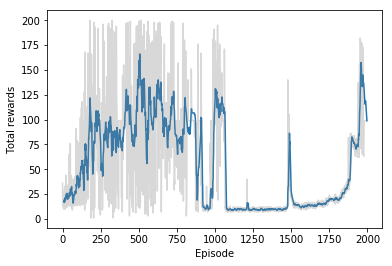

In [41]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

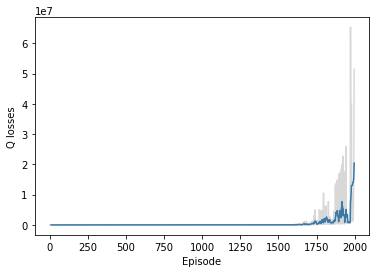

In [42]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

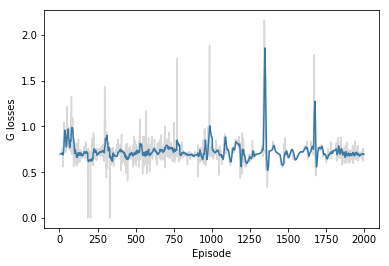

In [43]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

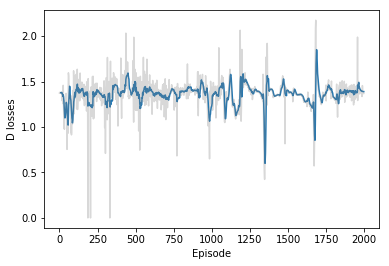

In [44]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [55]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000

# Create the env after closing it.
env = gym.make('CartPole-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/QGAN-cartpole-v1.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.